# EDA and Feature Selection

In [54]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

%matplotlib inline

pd.set_option('display.max_rows', 100) # to look at more rows of data later
pd.set_option('display.max_columns', 100) # to expand columns view so that all can be seen later

In [55]:
# Load datasets
train_df = pd.read_csv('../datasets/train_cleaned.csv')
test_df = pd.read_csv('../datasets/test_cleaned.csv')

Do a quick correlation check between sales price and the feature

In [56]:
top_20_features = np.abs(train_df.corr()[['saleprice']]).sort_values(by='saleprice',ascending=False).head(21).T.columns
top_20_features

Index(['saleprice', 'overallsf', 'overallqual', 'exterqual', 'kitchenqual',
       'garagearea', 'bsmtqual', 'age_house', 'garagefinish',
       'years_after_remod', 'fireplacequ', 'fullbath', 'foundation_PConc',
       'masvnrarea', 'totrmsabvgrd', 'fireplaces', 'heatingqc',
       'neighborhood_NridgHt', 'age_garage', 'bsmtexposure',
       'masvnrtype_None'],
      dtype='object')

Text(0.5, 1, 'Correlation between Sale Prices & Features')

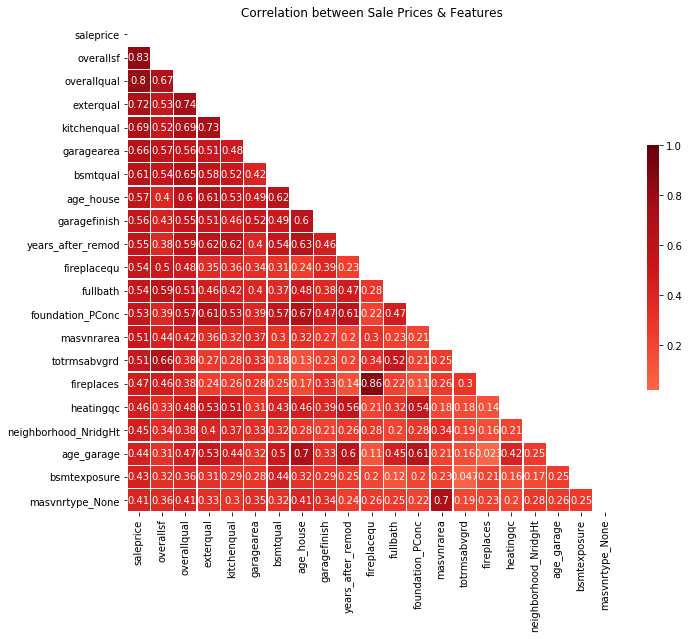

In [57]:
corr = train_df[top_20_features].corr().abs().sort_values(by='saleprice',ascending=False)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='Reds', vmax=1, center=0,annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title('Correlation between Sale Prices & Features')

We shall plot scatterplots and histograms to examine the relationship between the sale price and the features chosen.

In [58]:
def subplot_scatter(dataframe, column_x):
    nrows = int(np.ceil(len(column_x)/2)) # Makes sure you have enough rows
   #ncols = int(len(column_x))
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize = (20, 20))
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(column_x): # Gives us an index value to get into all our lists
        sns.regplot(x = column, y = 'saleprice', data = dataframe, ax = ax[i], color ='b')
        ax[i].set_title('Scatter of {} and {}'.format(column_x[i], 'saleprice'), fontsize = 12)
        ax[i].set_xlabel(column_x[i].replace('_', ' ').title(), fontsize = 12)
        ax[i].set_ylabel('saleprice', fontsize = 12)
       #ax[i].legend(column_x, loc = 'upper right')
        ax[i].grid(axis = 'y', alpha = 0.5) # set grid line, alpha is transparency
        fig.tight_layout()

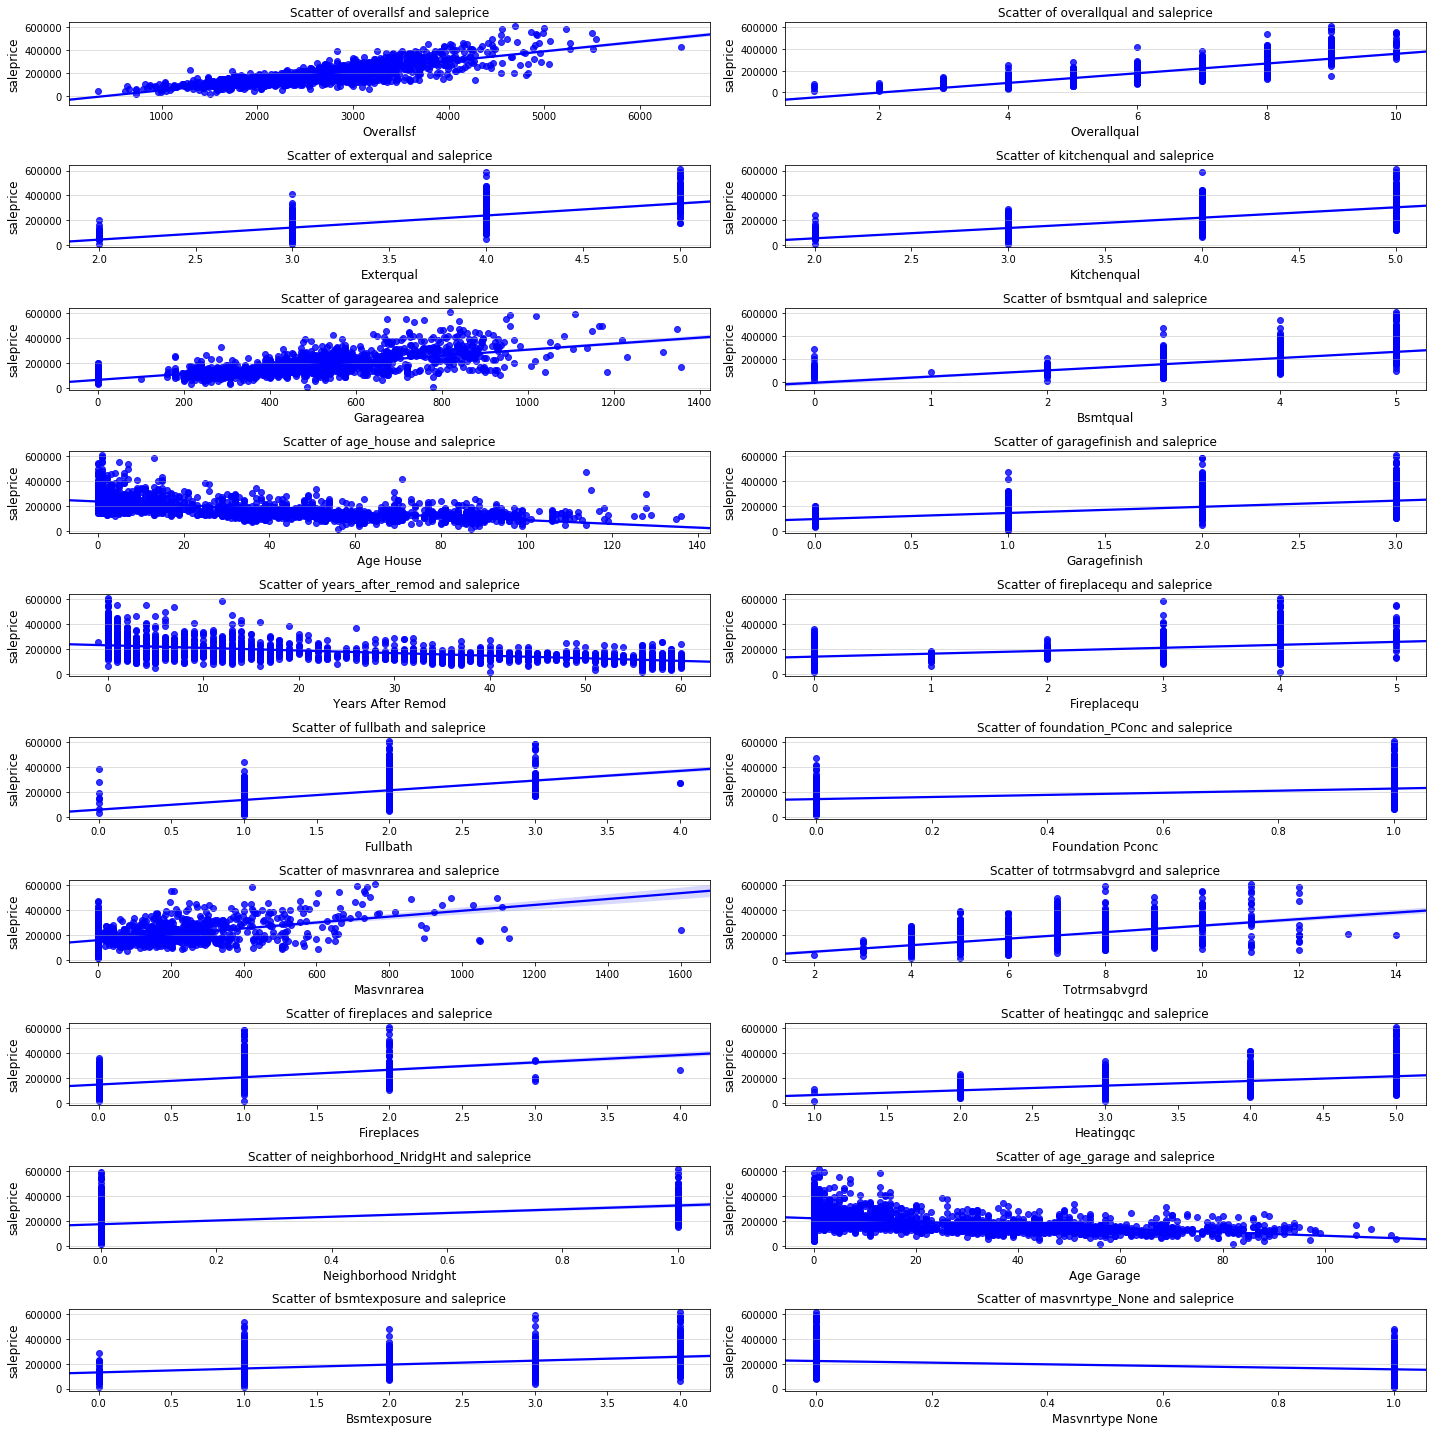

In [59]:
subplot_scatter(train_df,corr.columns[1:21])

From the scatterplots, we do see that prices of houses are generally higher for houses that have a greater area and better quality. Prices are also lower for older houses, garages and houses that has not been remod for a longer period of time.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000016606B8F208>,
      dtype=object)

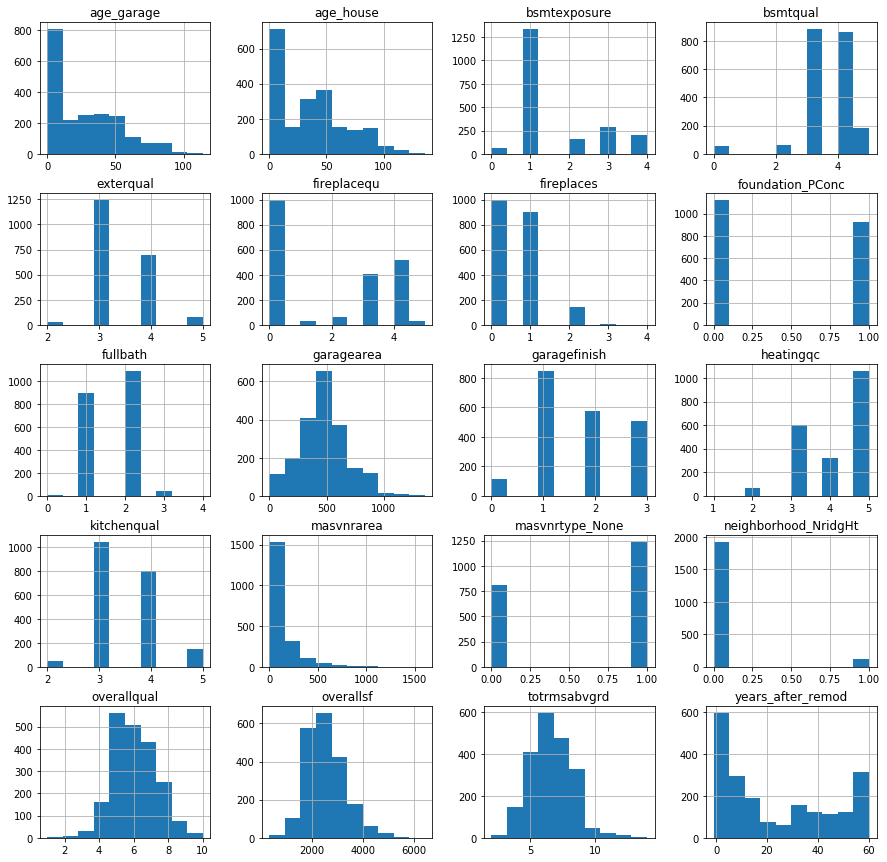

In [60]:
train_df[corr.columns[1:21]].hist(figsize=(15,15))

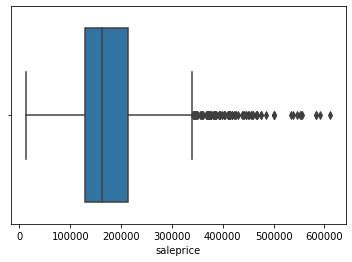

In [61]:
sns.boxplot(train_df['saleprice'])

## Modelling

We first write functions that will help in our modelling process later.

In [62]:
def run_all_model(X,y):
    model_list = ['lr','lasso','ridge','elasticnet']
    for i in model_list:
        print(f'Score for {i}: {run_model(i,X,y)}') 

def run_model(model_name,X,y): # This is to run model based on the model chosen.
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)
    X_train_sc, X_test_sc = run_SS(X_train,X_test)
    
    model = get_model(model_name)
    score = cross_val_score(model,X_train_sc,y_train,cv=5).mean()
    
    return score

def run_SS(X_train,X_test): # Initialise StandardScaler
    ss = StandardScaler()
    X_train_sc = ss.fit_transform(X_train)
    X_test_sc = ss.transform(X_test)
    return X_train_sc, X_test_sc

def get_model(model_name): # Initialise model to use to run
    model_dict = {
        'lr': LinearRegression(),
        'lasso': LassoCV(cv=3),
        'ridge': RidgeCV(),
        'elasticnet': ElasticNetCV(alphas=np.arange(0.5, 1.0, 0.005),cv=3)
    }
    return model_dict.get(model_name)

def predict_store_val(model_name,X_train,y,X_kaggle,file): # This is to predict the saleprice and store in csv
    ss = StandardScaler()
    X_train_sc = ss.fit_transform(X_train)
    X_kaggle_sc = ss.fit_transform(X_kaggle)
    model = get_model(model_name)
    model.fit(X_train_sc,y)
    score = model.score(X_train_sc,y)
    print(score)
    print(model.coef_)
    pred = model.predict(X_kaggle_sc)
    store_val(pred,file)
    
def store_val(pred,file):
    # Create dataframe for Kaggle submission
    df_soln = pd.DataFrame(test_df['id'])
    df_soln.rename(columns={'id':'Id'},inplace=True)
    df_soln['SalePrice'] = pred
    df_soln.set_index(['Id'], inplace=True)
    df_soln.to_csv(f'../datasets/{file}.csv')

### Model 1: Using the top 20 features that are strongly correlated with sale price.

In [63]:
features = corr.T.columns[1:21]
X = train_df[features]
y = train_df['saleprice']
X_kaggle = test_df[features]

In [64]:
run_all_model(X,y)

Score for lr: 0.8671427271526209
Score for lasso: 0.8672310115497208
Score for ridge: 0.8672831470932177
Score for elasticnet: 0.8602845817644343


In [65]:
predict_store_val('lasso',X,y,test_df[features],'test_submission')

0.867345455909855
[29917.98658947 14035.06184316  7181.74968156  8221.80247365
  7655.45522994 -2147.51656453 -3593.28798966  2492.07002886
 -3384.02339994   475.26539139 -2121.73650867   950.77951525
  9969.21705203  2988.59750643  6315.30211653  1486.05452548
  4930.780404    -684.56943244  7026.12903171  6298.71964627]


### Model 2: Applying polynomial features on the top 20 features.

In [67]:
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)
poly_train = pd.DataFrame(X_poly, columns = poly.get_feature_names(features))
poly_train['saleprice'] = train_df['saleprice']

X_poly_features = np.abs(poly_train.corr()[['saleprice']]).sort_values(by='saleprice',ascending=False)[1:21]
X_poly_features_columns = X_poly_features.T.columns

# run_model(poly_train[X_poly_features_columns],y)

### Prediction of sale price

In [69]:
X_kaggle_poly = poly.transform(X_kaggle)
poly_kaggle = pd.DataFrame(X_kaggle_poly,columns=poly.get_feature_names(features))

predict_store_val('ridge',poly_train[X_poly_features_columns],y,poly_kaggle[X_poly_features_columns],'test_sub')
poly_kaggle[X_poly_features_columns].shape


0.8929239608943331
[ 17916.00722857  20439.87762031  49423.36680103  34283.57408483
   6239.43340388    334.27108329 -10713.81889022   3811.43960272
 -52927.11575286  11742.02538564   2170.60385739   4295.83817047
   5837.13080431   6477.82775157  11631.07063622  -5284.24873981
  -6405.42446411  -9313.58518833 -15238.50428771  -1265.16371891]


(879, 20)

In [ ]:
X_poly_features_columns

In [ ]:
pd.Series(lasso.coef_, index=features).plot.bar(figsize=(15, 7))

In [ ]:
residuals = y_test - pred

In [ ]:
plt.scatter(pred, residuals)

### Model 3: Using a higher degree polynomial feature

In [75]:
poly2 = PolynomialFeatures(interaction_only=True, include_bias=False,degree=3)
X_poly2 = poly2.fit_transform(X)
poly_train2 = pd.DataFrame(X_poly2, columns = poly2.get_feature_names(features))
poly_train2['saleprice'] = train_df['saleprice']

X_poly_features2 = np.abs(poly_train2.corr()[['saleprice']]).sort_values(by='saleprice',ascending=False)[1:31]
X_poly_features_columns2 = X_poly_features2.T.columns
print(X_poly_features_columns2)
# run_model(poly_train[X_poly_features_columns],y)

Index(['overallsf overallqual kitchenqual', 'overallsf overallqual exterqual',
       'overallsf overallqual bsmtqual', 'overallsf overallqual',
       'overallsf kitchenqual bsmtqual', 'overallsf exterqual kitchenqual',
       'overallsf overallqual heatingqc', 'overallsf exterqual bsmtqual',
       'overallsf exterqual', 'overallsf kitchenqual',
       'overallsf overallqual garagearea', 'overallsf kitchenqual heatingqc',
       'overallsf kitchenqual garagearea', 'overallsf exterqual heatingqc',
       'overallsf bsmtqual', 'overallsf garagearea bsmtqual',
       'overallsf exterqual garagearea', 'overallsf bsmtqual heatingqc',
       'overallsf garagearea heatingqc', 'overallsf overallqual totrmsabvgrd',
       'overallqual kitchenqual totrmsabvgrd',
       'overallsf overallqual fullbath', 'overallqual exterqual totrmsabvgrd',
       'overallsf overallqual garagefinish',
       'overallqual bsmtqual totrmsabvgrd',
       'overallqual kitchenqual garagearea', 'overallqual garageare

In [76]:
X_kaggle_poly2 = poly2.transform(X_kaggle)
poly_kaggle2 = pd.DataFrame(X_kaggle_poly2,columns=poly2.get_feature_names(features))

predict_store_val('ridge',poly_train2[X_poly_features_columns2],y,poly_kaggle2[X_poly_features_columns2],'degree_3')



0.8942603371025052
[ -3804.46978567 -12972.66952772  35074.96483738  26906.6000112
 -18583.33844547    235.13215148 -26626.39282081  26206.80926845
 -34440.92516641  13632.62453471   5594.5925122    3209.03326366
  33086.98711397  23065.03426805   3800.8247391   -8210.96334323
  -3683.38887489   9112.76304271   -901.17635345   8752.34960513
  12465.22153881  -1046.42851411  19157.79248265  15217.52280041
 -27864.59173438 -16549.39254577   5383.41975054   7413.98100482
  -6917.67146994  -7615.70963518]
